# Project Overview

Step 1 - Baseline 

Develop a binary classification model to distinguish between fake and authentic news articles using the Fake-And-Real News Kaggle dataset : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset 

 
The dataset contains articles from 3 domains: News, Politics, and Other.  

 

Evaluate model performance using appropriate metrics (accuracy, precision, recall, F1):  

- Overall performance across all domains  
- Performance stratified by domain  
 

Conduct feature importance analysis to identify key predictors that differentiate authentic from fake news across the three domains.  

 

You may use any modeling approach - pre-trained models, custom architectures, or ensemble methods.  

 

Step 2 - Improvement 

After establishing your baseline model and completing initial analysis, implement techniques to improve model performance.  

 

Potential improvement directions: 

- auxiliary datasets to augment the provided data 
- we value your expertise in identifying relevant supplementary sources.  
- advanced feature engineering 
- different model architectures 
- ensemble methods 
 

Document your methodological decisions and quantify performance improvements with appropriate metrics.  

# 0 - Import Packages

In [1]:
import numpy as np
import pandas as pd 
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import plot_importance
from xgboost import XGBClassifier

# Open files

In [2]:
true_df = pd.read_csv(r'C:\Users\HP\Downloads\fake-and-real-news\True.csv')
fake_df = pd.read_csv(r'C:\Users\HP\Downloads\fake-and-real-news\Fake.csv')

print(true_df.isnull().sum())
print(fake_df.isnull().sum())

title      0
text       0
subject    0
date       0
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64


# Step 1 - Baseline 

# Data Cleaning

In [3]:
true_df['label'] = 0
fake_df['label'] = 1

df = pd.concat([true_df, fake_df])
df = df.sample(frac=1, random_state = 42).reset_index(drop=True) # randomly shuffles all the rows of the DataFrame and properly resets the index

print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1
5,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",0
6,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",0
7,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",0
8,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",1
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",1


In [4]:
# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'$$.*?$$', '', text) # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>+', '', text) # remove HTML tags
    text = re.sub(r'\n', '', text) # remove newline characters
    text = re.sub(r'\w*\d\w*', '', text) # remove words that contain digits (e.g., 'abc123', '4you', etc.)
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    # tokens = word_tokenize(text) # Tokenize
    # tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]


    text = re.sub(r'\breuters\b', '', text)  # Remove the word "reuters"


    return text
    # return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

Using WordNetLemmatizer, stopwords and word_tokenize from nltk could improve our cleaning and give better results but I have issues to install this library. 
I think that removing stop_words such as the, is, and, etc., is a good idea to clean text as they have no strong semantic value.

However, lemmatize, which brings each word back to its canonical form or root (e.g., running becomes run), can lower the model's performance. I think that a fake article is distinguished by words specifically chosen to surprise or shock, and bringing those words back to their canonical form can make the article look like a real one, which are also "lemmatized". 

# Exploratory Data Analysis

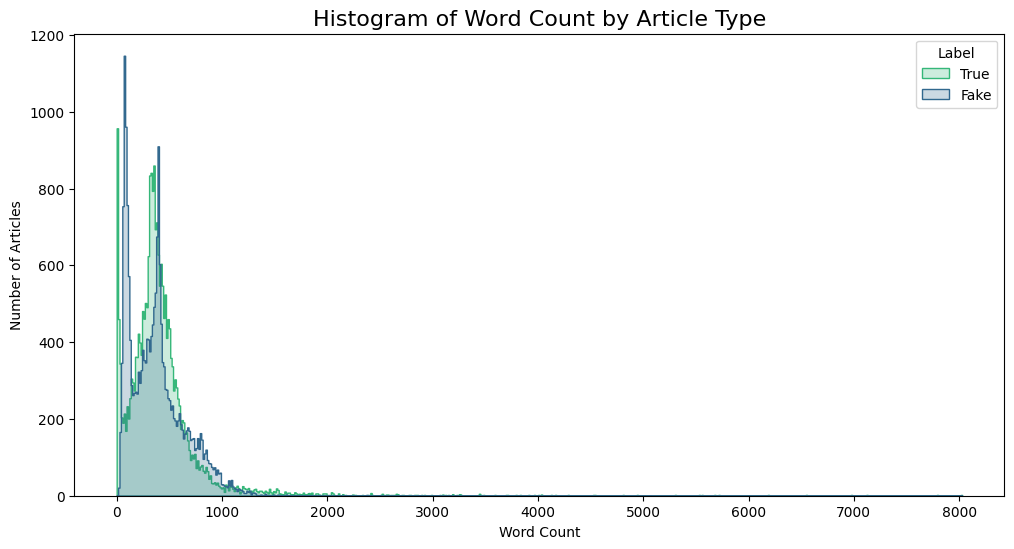

In [5]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', bins=600, palette='viridis', element='step', stat='count')
plt.title('Histogram of Word Count by Article Type', fontsize=16)
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.legend(title='Label', labels=['True', 'Fake'])
plt.show()

Fake articles tend to be shorter, possibly because they get straight to the point with catchy headlines or sensationalist content.

True articles cover a wider range of lengths, perhaps because of more in-depth journalism or detailed reporting.

We will add an article length feature to our dataset

### correlation study

Subject correlation

Correlation between each subject and the label:
subject_News               0.479858
subject_politics           0.404915
subject_left-news          0.317132
subject_Government News    0.181797
subject_US_News            0.127236
subject_Middle-east        0.126822
subject_worldnews         -0.565730
subject_politicsNews      -0.606236
Name: label, dtype: float64


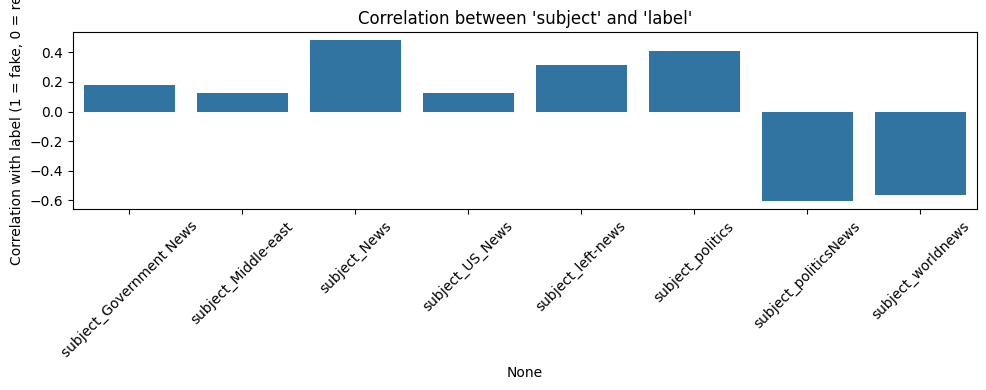

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


subject_dummies = pd.get_dummies(df['subject'], prefix='subject') # One-hot encode the 'subject' column
df_encoded = pd.concat([subject_dummies, df['label']], axis=1)
correlations = df_encoded.corr(numeric_only=True)['label'].drop('label') # # Compute correlations

print("Correlation between each subject and the label:")
print(correlations.sort_values(ascending=False)) # Display correlations

plt.figure(figsize=(10, 4)) # heatmap
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45)
plt.ylabel("Correlation with label (1 = fake, 0 = real)")
plt.title("Correlation between 'subject' and 'label'")
plt.tight_layout()
plt.show()


The strong inverse correlation of articles labelled as politicsNews or Worldnews indicates their tendency to be real (label = 0).
The more an article belongs to one of these categories, the less likely it is to be ‘fake’.

Conversely, subjects with a positive correlation (such as News, left-news, etc.) are associated with ‘fake’ labels. Only News' positive correlation of 0.480027 is high enough to consider a tendency to be fake. To be considered with caution

However, keeping the category subject as a feature may promote overfitting and reduce the objectivity of the model.
The model may associate "subject = News" with "label = fake" without actually understanding the content of the article or detecting misinformation in a general way.
We will therefore remove this column from our dataset to focus more on the actual content of the article.

date correlation

In [51]:
print("Before parsing:")
print(df['label'].value_counts())

# Parse the 'date' column, coercing errors to NaT (Not a Time)
df['parsed_date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['parsed_date'].dt.month

print("\nAfter parsing (NaT if parsing failed):")
print(df[['date', 'parsed_date', 'label']].head(10))

print("\nLabel counts with valid parsed dates:")
print(df.dropna(subset=['parsed_date'])['label'].value_counts())



Before parsing:
label
1    23481
0    21417
Name: count, dtype: int64

After parsing (NaT if parsing failed):
                 date parsed_date  label
0       July 21, 2017  2017-07-21      1
1         May 7, 2016  2016-05-07      1
2    December 3, 2016  2016-12-03      1
3    October 6, 2017          NaT      0
4        Apr 25, 2017         NaT      1
5   February 1, 2017          NaT      0
6   October 28, 2017          NaT      0
7  September 6, 2017          NaT      0
8        Feb 24, 2016         NaT      1
9         Feb 4, 2017         NaT      1

Label counts with valid parsed dates:
label
1    11868
Name: count, dtype: int64


All the labels == 0 are associated with badly formatted dates and so are half the labels == 1. If I had used the same programme as the previous one, these badly formatted dates would have been removed and the correlation impossible. I reparsed the dates correctly before studying the correlation of dates with labels. 

Label distribution with valid parsed dates:
label
1    23471
0    21417
Name: count, dtype: int64

Correlation between each month and the label:
month_5.0     0.100384
month_4.0     0.092669
month_7.0     0.086591
month_1.0     0.085402
month_8.0     0.078515
month_6.0     0.073845
month_3.0     0.071026
month_2.0     0.069735
month_12.0   -0.111117
month_10.0   -0.122012
month_9.0    -0.131634
month_11.0   -0.148078
Name: label, dtype: float64


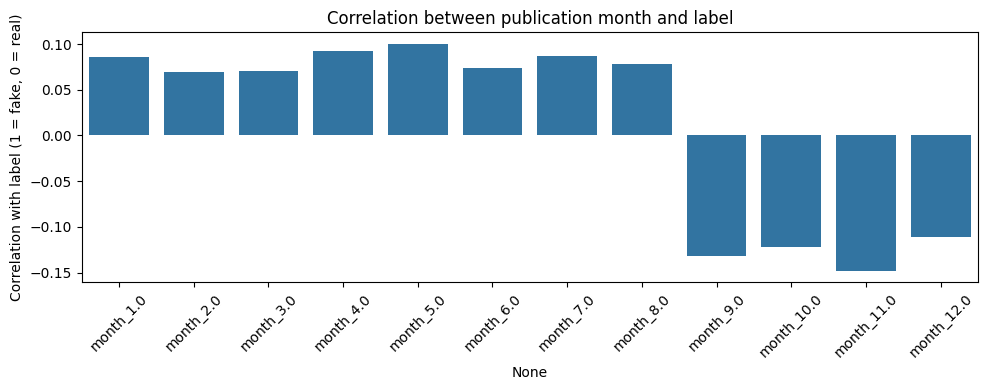

In [52]:
def safe_parse_date(date_str):  # Parse the 'date' column more robustly
    try:
        return parser.parse(date_str)
    except:
        return pd.NaT


df = df.copy()
df['parsed_date'] = df['date'].apply(safe_parse_date)
df['month'] = df['parsed_date'].dt.month

print("Label distribution with valid parsed dates:")
print(df.dropna(subset=['month'])['label'].value_counts()) # Check label distribution after parsing

df = df.dropna(subset=['month'])

month_dummies = pd.get_dummies(df['month'], prefix='month') # One-hot encode the 'month' column

df_encoded = pd.concat([month_dummies, df['label']], axis=1)

correlations = df_encoded.corr(numeric_only=True)['label'].drop('label')

print("\nCorrelation between each month and the label:")
print(correlations.sort_values(ascending=False))

plt.figure(figsize=(10, 4)) # plot the correlations
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45)
plt.ylabel("Correlation with label (1 = fake, 0 = real)")
plt.title("Correlation between publication month and label")
plt.tight_layout()
plt.show()


In absolute value, the correlations of the months with the label are below 0.15, which indicates that there is no particular month during which fake news floods the media. We will therefore remove this column from the dataset to eliminate this unnecessary noise.

In [ ]:
df.drop(['subject','date', 'parsed_date', 'month'], axis=1, inplace=True)
# df.head(10)

# Model(s)

In [6]:
X = df[["title", "clean_text","word_count"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from scipy.sparse import hstack, csr_matrix

# Train
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["title"] + " " + X_train["clean_text"])
X_train_extra = csr_matrix(X_train[["word_count"]].values)
X_train_tfidf = hstack([X_train_tfidf, X_train_extra])

# Test
X_test_tfidf = tfidf_vectorizer.transform(X_test["title"] + " " + X_test["clean_text"])
X_test_extra = csr_matrix(X_test[["word_count"]].values)
X_test_tfidf = hstack([X_test_tfidf, X_test_extra])

In [58]:
models = [
    MultinomialNB(),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42)
]

for model in models:
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__}: {accuracy*100:.2f}")
    print("-"*30)

MultinomialNB: 92.50
------------------------------


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: 98.28
------------------------------
DecisionTreeClassifier: 99.63
------------------------------
RandomForestClassifier: 99.32
------------------------------


These first basic models already give us excellent results !
We see that MultinomialNB is much weaker than the others, so we will not continue with it.
LogisticRegression is good but less performant than DecisionTreeClassifier and RandomForestClassifier. Therefore, we will not continue with it either.

Finally, DecisionTreeClassifier is the best with 99.63, and RandomForestClassifier is just below with 99.32. It's possible that cross-validation could narrow these results, but for time-saving reasons, we will perform it only on the DecisionTreeClassifier. I prefer to keep more time to explore more complex models in step 2

# Cross-validation of the best model

## DecisionTreeClassifier 

DecisionTreeClassifier Cross-Validation Accuracies:
Fold 1: 99.54%
Fold 2: 99.51%
Fold 3: 99.58%
Fold 4: 99.76%
Fold 5: 99.51%
------------------------------
Mean Accuracy: 99.58%



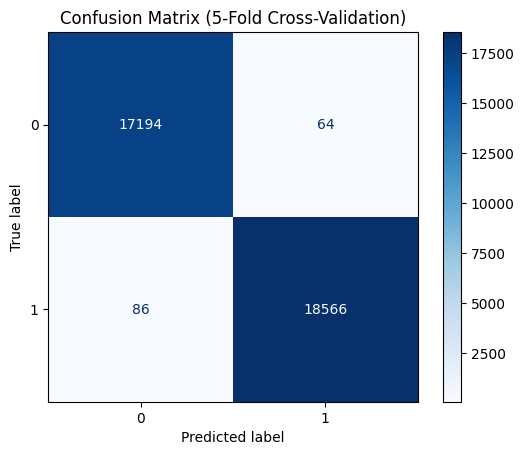

Classification Report:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00     17258
        Fake       1.00      1.00      1.00     18652

    accuracy                           1.00     35910
   macro avg       1.00      1.00      1.00     35910
weighted avg       1.00      1.00      1.00     35910



In [60]:
# Modèle
dt_model = DecisionTreeClassifier(random_state=42)

# 1. Cross-validation scores
cv_scores = cross_val_score(dt_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs=-1 : Use all available CPU cores

print("DecisionTreeClassifier Cross-Validation Accuracies:")
for i, score in enumerate(cv_scores):
    print(f"Fold {i+1}: {score*100:.2f}%")
print("-" * 30)
print(f"Mean Accuracy: {np.mean(cv_scores)*100:.2f}%\n")

# Cross-validation predictions (to analyse confusion matrix + report)
y_pred_cv = cross_val_predict(dt_model, X_train_tfidf, y_train, cv=5, n_jobs=-1)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (5-Fold Cross-Validation)")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_cv, target_names=["True", "Fake"]))


I forgot the digits

In [63]:
print(classification_report(y_train, y_pred_cv, target_names=["True", "Fake"], digits=4))

              precision    recall  f1-score   support

        True    0.99502   0.99629   0.99566     17258
        Fake    0.99656   0.99539   0.99598     18652

    accuracy                        0.99582     35910
   macro avg    0.99579   0.99584   0.99582     35910
weighted avg    0.99582   0.99582   0.99582     35910



When it comes to detecting fake news, it's more important to know how many false positives there are than true negatives, because fake news considered to be true can be devastating.

False Positive (FP): A fake news article incorrectly classified as true → critical

False Negative (FN): A true news article incorrectly classified as fake → less critical

To evaluate the model's ability to identify fake news as false, we use precision:

for the True class (label = 0):

Precision = True Negatives / (True Negatives + False Positives) = 0.99502

If the model predicted 1000 articles as true, approximately 0.5% (5 articles) are actually false positives, that is, fake news incorrectly classified as true. 



# GridSearch 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [10, 20, 30, None], # best : None
    'min_samples_leaf': [1, 2, 4], # # best : 1 but it must be None if we try it 
    'criterion': ['gini', 'entropy'] # best : gini 
}

# default parameters are the best
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

The GridSearch was carried out for the sake of rigour, but it is a very time-consuming procedure, and having tested several values, it confirmed that the default parameters of the DecisionTreeClassifier are the most suitable.

# Feature Importance

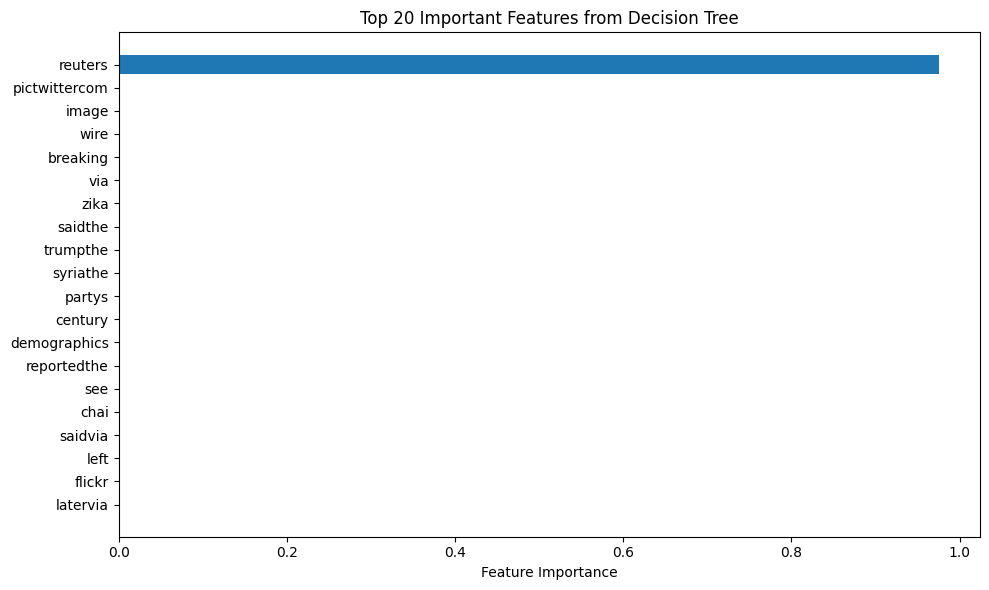

In [64]:
# 1. Get feature names from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 2. Append the name for the extra feature(s)
all_feature_names = np.append(tfidf_feature_names, ["word_count"])

# 3. Fit the model
dt_model.fit(X_train_tfidf, y_train)

# 4. Get feature importances
importances = dt_model.feature_importances_

# 5. Get indices of top 20 features
indices = np.argsort(importances)[::-1][:20]

# 6. Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features from Decision Tree")
plt.tight_layout()
plt.show()




In [65]:
# Count how many articles contain the word "reuters"
contains_reuters = df['text'].str.contains(r'\breuters\b', case=False, na=False)

# Calculate the percentage
percentage_reuters = contains_reuters.mean() * 100

print(f"Percentage of articles containing the word 'reuters': {percentage_reuters:.2f}%")


Percentage of articles containing the word 'reuters': 48.31%


In [67]:
# Percentage in each category
true_pct = df[df['label'] == 0 ]['text'].str.contains(r'\breuters\b', case=False, na=False).mean() * 100
fake_pct = df[df['label'] == 1  ]['text'].str.contains(r'\breuters\b', case=False, na=False).mean() * 100

print(f"True articles with 'reuters': {true_pct:.2f}%")
print(f"Fake articles with 'reuters': {fake_pct:.2f}%")


True articles with 'reuters': 99.82%
Fake articles with 'reuters': 1.31%


# WARNING : OVERFITTING

The model simply detects the source ('reuters') to predict that the article is true, without analyzing the actual content of the text. I will remove the word during the cleaning step using:

df['text'] = df['text'].str.replace(r'\breuters\b', '', case=False, regex=True)

In [8]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)

y_pred = dt_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9606


After rerunning the cleaning process by removing the word 'reuters', we observed a drop in accuracy. However, it remains high, and we can be confident that our model performs well on another dataset !

# Step 2 : advanced model , XGBoost 

In [9]:
# Initialisation
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_tfidf, y_train), 1):
    X_train_fold, X_val_fold = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_train_fold, y_train_fold)
    y_pred = xgb_model.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred)
    accuracies.append(acc)

    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc*100:.2f}%")

# Summary
print("\n--- Global Results ---")
print(f"Mean Accuracy: {np.mean(accuracies)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred))
print("Confusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Accuracy: 99.07%


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Accuracy: 99.15%


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:57:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Accuracy: 99.19%


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:00:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 Accuracy: 99.23%


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 Accuracy: 99.25%

--- Global Results ---
Mean Accuracy: 99.18%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17106
           1       0.99      0.99      0.99     18812

    accuracy                           0.99     35918
   macro avg       0.99      0.99      0.99     35918
weighted avg       0.99      0.99      0.99     35918

Confusion Matrix:
[[16973   133]
 [  162 18650]]


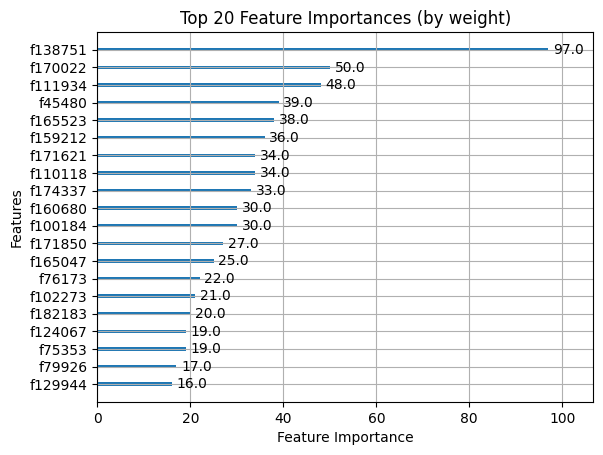

In [10]:
# Affiche l'importance des features (après entraînement du modèle)
plot_importance(xgb_model, max_num_features=20, importance_type='weight', xlabel='Feature Importance')
plt.title("Top 20 Feature Importances (by weight)")
plt.show()

XGBoost has by far the best score, even after removing the word "reuters." Moreover, the feature importance graph is more balanced than the previous one. However, it would be interesting to understand what lies behind these feature codes.

# Conclusion:

At the end of this challenge, we built a performant model for detecting fake news. Unfortunately, I discovered the data leakage quite late within the time limit, but I would like to suggest some possible improvements:

1) In the cleaning step, I would add:
tokens = word_tokenize(text)  # Tokenize  
tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
and I would re-test my models to see how this processing affects performance.

2) I would explore the feature importance graph of the XGBoost model further to check whether data leakage appears again (particularly with the first feature, which has a weight twice as high as the second one).

3) I would test other models, such as Hugging Face transformers like  BERT, DistilBERT, RoBERTa, etc with tranformers from HuggingFace.

4) I would look for online datasets with a similar structure to confirm whether my model generalises well after correcting for the leakage.